In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import namedtuple
%matplotlib inline

import utils

plt.rcParams['figure.figsize'] = [20, 12]

In [2]:
ONE_DAY = pd.Timedelta("1D")
Args = namedtuple("Args", "rolling_mean est_window smooth model_cov_weight")

In [3]:
def process_data(data, country, args):
    data = data.loc[:,(slice(None),country)].copy()
    data = data.droplevel(1, axis=1)
    data = data.dropna(how="all")
    data = data.fillna(0)
    data[data<0]=0
    # data = data[data.index>"2020-06-01"]
    cases = np.log(data.new_cases_per_million+1)
    deaths = np.log(data.new_deaths_per_million+1)


    filt_cases = utils.filter_const_v(cases,args).dropna()
    filt_deaths = utils.filter_const_v(deaths,args).dropna()
    corr_cases = filt_cases.V
    corr_deaths = filt_deaths.V
    corr_cases = corr_cases.fillna(0)
    corr_deaths = corr_deaths.fillna(0)
#     fig=plt.figure()
#     plt.plot(corr_cases,label="case daily change %age")
#     plt.plot(corr_deaths,label="death daily change %age")
#     plt.legend()
#     plt.grid()
#     corr = np.correlate(filt_cases.V,filt_deaths.V, mode="full")
    corr = np.correlate(corr_cases,corr_deaths, mode="full")
    offset = len(filt_cases)-corr.argmax()
    print(f"{country}: {offset}")
    filt_cases.index = filt_cases.index + ONE_DAY*offset

#     fig=plt.figure()
#     plt.plot(np.arange(len(corr))-len(filt_cases),corr, label=f"death-case xcorr: {offset} day delay")
#     plt.legend()
#     plt.grid()
    
    vaccinated = (data.people_vaccinated_per_hundred).copy()
    vaccinated.index = vaccinated.index + ONE_DAY*21
    vaccinated = vaccinated[vaccinated>0]

    return vaccinated,filt_cases,filt_deaths, offset

def final_plot(vaccinated,filt_cases,filt_deaths, offset,country, save_filename=None):
    death_rate = np.exp(filt_deaths.X-filt_cases.X)
    fig=plt.figure()
    ax1=plt.gca()
    ax2=ax1.twinx()

    ax2.plot(vaccinated,"--",color="firebrick",label="1st vaccination %age + 3 weeks")
    ax2.set_ylim([0,100])
    ax2.set_ylabel("vaccination %age")
    ax2.legend(loc="upper right")
    #ax1.set_xlim([pd.to_datetime("2020-09-01"),None])
    ax2.grid(which="major",color="r")
    ax1.plot(death_rate, label="est death rate")
    ax1.plot(np.exp(filt_deaths.X), label="deaths per M")
    ax1.plot(np.exp(filt_deaths.X_unfiltered),label="filtered deaths per M")


    ax1.plot(np.exp(filt_cases.X), label = f"cases (shifted {offset} days to match deaths) per M")
    ax1.plot(np.exp(filt_cases.X_unfiltered), label = "filtered cases")
    ax1.set_yscale("log")
    ax1.legend(loc="upper left")
    ax1.grid()
    ax1.grid(which="minor")
    ax1.set_title(f"Vaccination progress for {country}")
    if save_filename: 
        plt.savefig(save_filename+country+".png")

In [4]:
data = utils.read_owid_data(

    "data/owid-covid-data.csv",
    values=[
        "new_cases_per_million",
        "new_deaths_per_million",
        "people_vaccinated_per_hundred"
    ],
)

Israel: 16
United_Kingdom: 15
United_States: 12
Germany: 18
France: 14


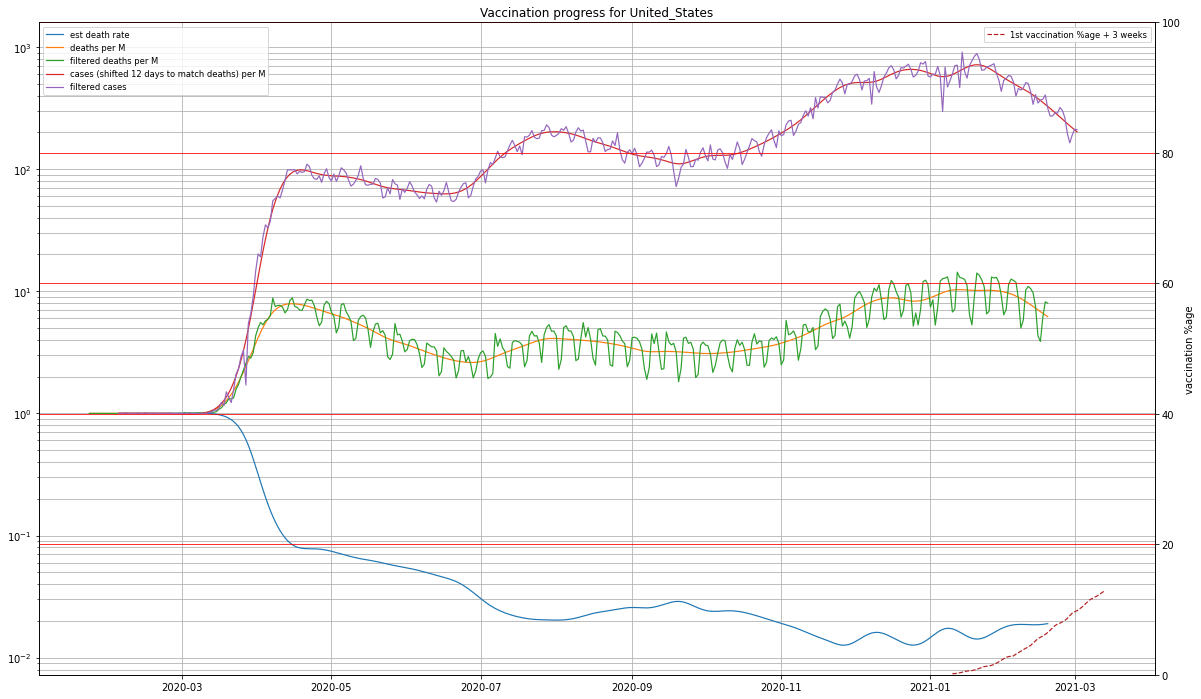

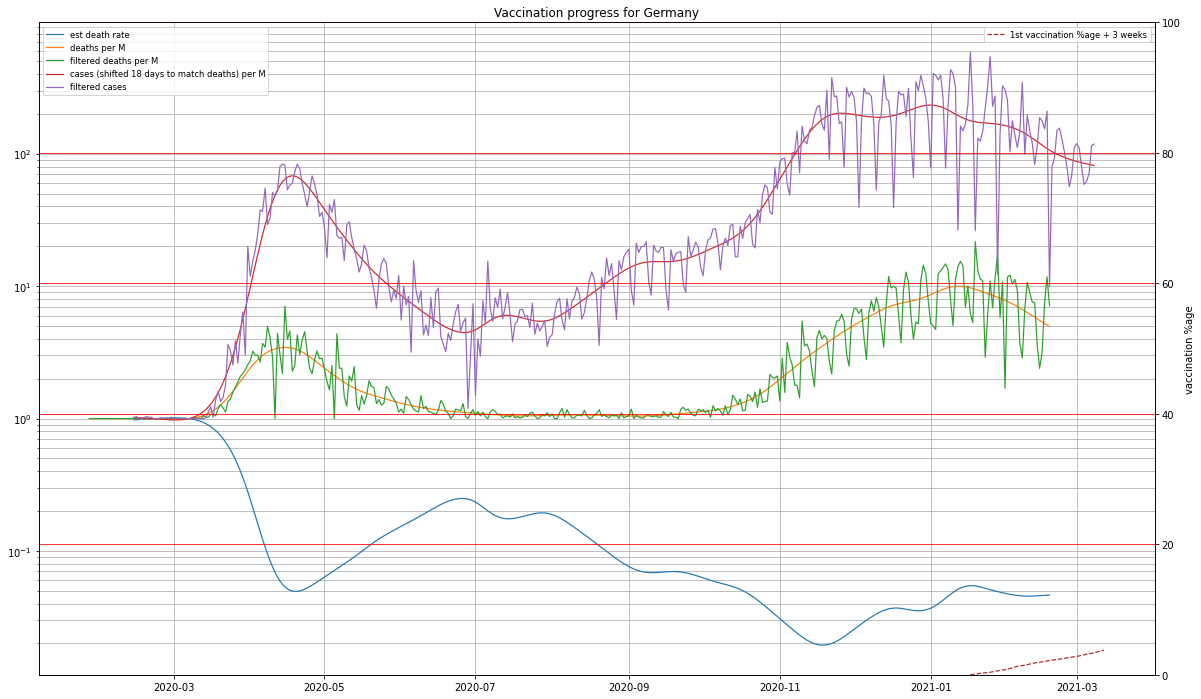

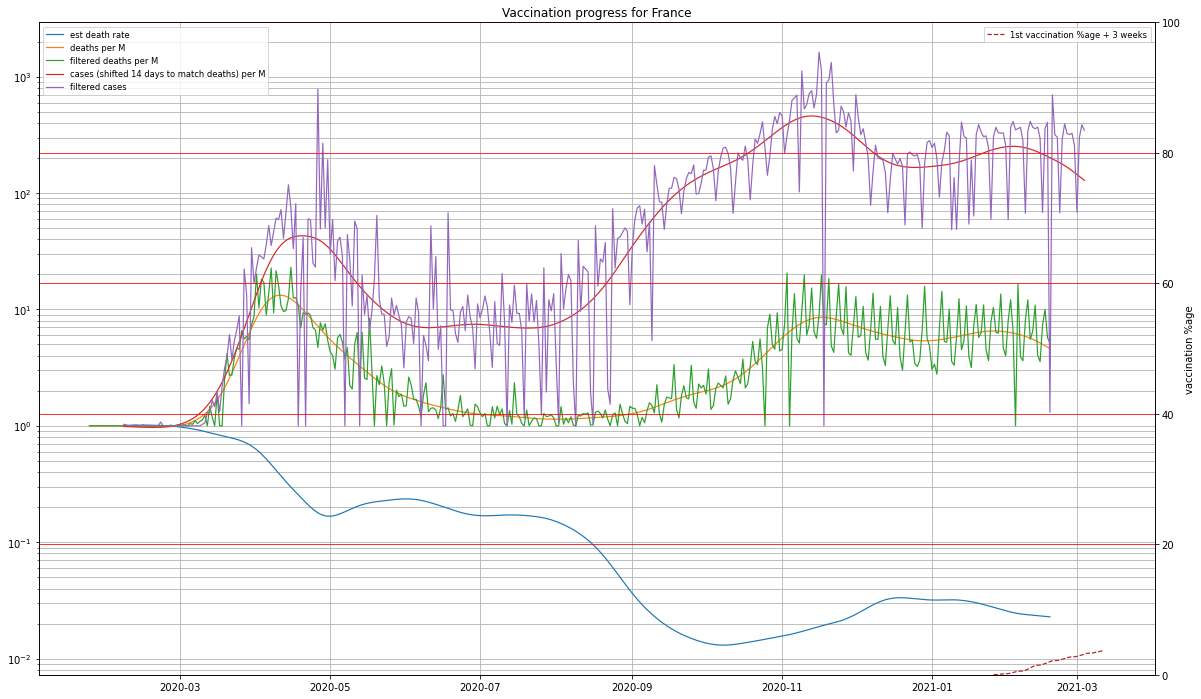

In [5]:
args = Args(rolling_mean=7, smooth=True,model_cov_weight=0.000001, est_window=7)
countries = ["Israel","United_Kingdom", "United_States", "Germany","France"]
for country in countries:
    vaccinated,filt_cases,filt_deaths, offset = process_data(data,country, args)
    final_plot(vaccinated,filt_cases,filt_deaths, offset,country, "death_rate_")